## Homework 2
This notebook contains the solutions for the second homework assignment of the Machine Learning Zoomcamp 2025 course, which can be viewed on github with the following [link](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/02-regression/homework.md). The final solutions notebook is submitted for grading at the following [link](https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw02).
### Setup

In [2]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Load the dataset from the following url
url_path = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
# Prepend this string to final answers so they print as bold text
BOLD = "\033[1m"

In [4]:
# Load data and inspect it
cfe_df = pd.read_csv(url_path)
cfe_df.info()
cfe_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
5,190,3.0,NaN,2484.883986,14.7,2008,Europe,Gasoline,All-wheel drive,-1.0,17.271818
6,240,7.0,127.0,3006.542287,22.2,2012,USA,Gasoline,Front-wheel drive,1.0,13.210412
7,150,4.0,239.0,3638.657780,17.3,2020,USA,Diesel,All-wheel drive,1.0,12.848884
8,250,1.0,174.0,2714.219310,10.3,2016,Asia,Diesel,Front-wheel drive,-1.0,16.823554
9,150,4.0,123.0,3509.036569,10.2,2005,USA,Gasoline,Front-wheel drive,-1.0,12.298355


#### Preprocessing

In [5]:
cols_to_keep = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year','fuel_efficiency_mpg']
pp_df = cfe_df[cols_to_keep].copy()
pp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   horsepower           8996 non-null   float64
 2   vehicle_weight       9704 non-null   float64
 3   model_year           9704 non-null   int64  
 4   fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 379.2 KB


#### EDA
That's one beautiful looking bell-shaped curve -> no need for rescaling of the target variable.

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

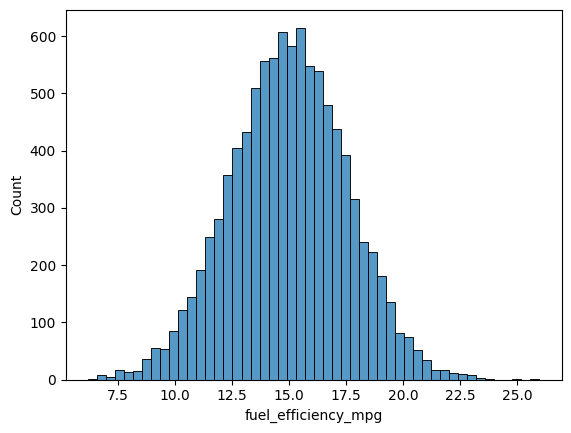

In [6]:
sns.histplot(pp_df['fuel_efficiency_mpg'], bins=50)

#### Define functions

In [20]:
# Split the dataset
def split_train_val_test(df, val_ratio, test_ratio, r_seed, verbose=False):
    """Split input dataframe into randomly shuffled train, validation,
    and test datasets with the validation dataset containing val_ratio of the
    input data and the test dataset containing test_ratio of the input data.
    """
    n = len(df)
    n_val = int(val_ratio * n)
    n_test = int(test_ratio * n)
    n_train = n - n_val - n_test
    # Randomly shuffle input data's index
    idx = np.arange(n)
    np.random.seed(r_seed)
    np.random.shuffle(idx)
    # Generate train, validation, and test splits
    train_df = df.iloc[idx[:n_train]]
    val_df = df.iloc[idx[n_train:n_train+n_val]]
    test_df = df.iloc[idx[n_train+n_val:]]
    if verbose:
        print(f"All rows in the original dataframe are contained within the training, validation, or test datasets: {len(train_df) + len(val_df) + len(test_df) == len(df)}")
    return train_df, val_df, test_df

# Prepare X and y
def prepare_X_y(df, target_col="fuel_efficiency_mpg", na_val=0, verbose=False, label=" "):
    pdf = df.copy()
    y = pdf[target_col].values
    X = pdf.drop(columns=target_col).fillna(na_val).values
    if verbose:
        print(f"All {len(df)} rows in the{label}dataframe are contained within X and y: {len(X) == len(y) == len(df)}\n")
    return X, y

# Train linear regression model
def train_linear_regression(X, y, reg=0, verbose=False):
    """Train a linear regression model using the normal equations, include
    L2 regularization (i.e. damping), reg.
    """
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    if reg:
        reg = reg * np.eye(X.shape[1])
    XTX_inv = np.linalg.inv(X.T.dot(X) + reg)
    w = XTX_inv.dot(X.T).dot(y)
    if verbose:
        print(f"Model parameters are as follows: w0 = {w[0]}, w = {w[1:]}\n")
    return w[0], w[1:]

# Predict y
def predict_y(X, w0, w):
    return w0 + X.dot(w)

# Calculate RMSE
def compute_rmse(y, y_pred, round_flag=False, round_dec=2, verbose=False, data_label="", prep_label=""):
    """Compute Root Mean Square Error (RMSE) rounded to 2 decimal places."""
    se = (y - y_pred) ** 2
    rmse = np.sqrt(se.mean())
    if round_flag:
        rmse = round(rmse, round_dec)
    if verbose:
        print(f"{data_label}RMSE{prep_label} = {rmse}\n")
    return rmse

# Print whether RMSE for Q3 changed
def get_rmse_change_str(rmse_0, rmse_mean):
    if rmse_0 > rmse_mean:
        return "With mean"
    elif rmse_0 < rmse_mean:
        return "With 0"
    else:
        return "Both are equally good"

### Q1. Column with missing values

In [8]:
print(f"The following column contains missing values: {BOLD}{pp_df.columns[pp_df.isna().sum() > 0][0]}")

The following column contains missing values: horsepower


### Q2. Median horsepower

In [9]:
print(f"The median horsepower value is {BOLD}{pp_df['horsepower'].median():0.2f}")

The median horsepower value is 149.00


### Q3. Effect of data imputation on RMSE
- We need to deal with missing values for the column from Q1. We have two options: fill it
  1. with 0 or
  2. with the mean
- Try both options. For each,
  1. train a linear regression model without regularization using the code from the lessons. For computing the mean, use the training only!
  2. use the validation dataset to evaluate the models and compare the RMSE of each option. Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?


In [10]:
# Generate training, validation and test datasets
val_ratio = 0.2
test_ratio = 0.2
r_seed = 42
train_df, val_df, test_df = split_train_val_test(pp_df, val_ratio, test_ratio, r_seed, verbose=True)

All rows in the original dataframe are contained within the training, validation, or test datasets: True


In [21]:
# Train model with horsepower NA values filled with 0
X_train_hp0, y_train_hp0 = prepare_X_y(train_df, verbose=True, label=" training ")
w0_hp0, w_hp0 = train_linear_regression(X_train_hp0, y_train_hp0, verbose=True)
y_pred_train_hp0 = predict_y(X_train_hp0, w0_hp0, w_hp0)
rmse_train_hp0 = compute_rmse(y_train_hp0, y_pred_train_hp0, round_flag=True, verbose=True, data_label="Training ", prep_label=" with HP NAs filled with 0")

# Apply model to validation dataset with horsepower NA values filled with 0
X_val_hp0, y_val_hp0 = prepare_X_y(val_df, verbose=True, label=" validation ")
y_pred_val_hp0 = predict_y(X_val_hp0, w0_hp0, w_hp0)
rmse_val_hp0 = compute_rmse(y_val_hp0, y_pred_val_hp0, round_flag=True, verbose=True, data_label="Validation ", prep_label=" with HP NAs filled with 0")

All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 27.513852581224892, w = [-7.49245681e-05  3.51310422e-03 -5.02056083e-03  1.02939922e-03]

Training RMSE with HP NAs filled with 0 = 0.52

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.51



In [22]:
# Train model with horsepower NA values filled with mean
hp_train_mean = {'horsepower': train_df['horsepower'].mean()}
X_train_hpmean, y_train_hpmean = prepare_X_y(train_df, na_val=hp_train_mean, verbose=True, label=" training ")
w0_hpmean, w_hpmean = train_linear_regression(X_train_hpmean, y_train_hpmean, verbose=True)
y_pred_train_hpmean = predict_y(X_train_hpmean, w0_hpmean, w_hpmean)
rmse_train_hpmean = compute_rmse(y_train_hpmean, y_pred_train_hpmean, round_flag=True, verbose=True, data_label="Training ", prep_label=" with HP NAs filled with Mean")

# Evaluate model with validation dataset using horsepower NA values filled with Mean
X_val_hpmean, y_val_hpmean = prepare_X_y(val_df, na_val=hp_train_mean, verbose=True, label=" validation ")
y_pred_val_hpmean = predict_y(X_val_hpmean, w0_hpmean, w_hpmean)
rmse_val_hpmean = compute_rmse(y_val_hpmean, y_pred_val_hpmean, round_flag=True, verbose=True, data_label="Validation ", prep_label=" with HP NAs filled with Mean")

All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 27.672575469399483, w = [ 7.55264124e-05  1.00350250e-02 -5.02056898e-03  4.30803051e-04]

Training RMSE with HP NAs filled with Mean = 0.47

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with Mean = 0.46



In [23]:
print(f"Which horsepower missing values approach yields a lower RMSE? {BOLD}{get_rmse_change_str(rmse_val_hp0, rmse_val_hpmean)}")

Which horsepower missing values approach yields a lower RMSE? With mean


### Q4. R with best RMSE
Train a regularized linear regression.
  1. Fill the NAs with 0
  2. Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100]
  3. Use RMSE to evaluate the model on the validation dataset. Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE? If there are multiple options, select the smallest r.

In [24]:
reg_vals = [0, 0.01, 0.1, 1, 5, 10, 100]
reg_val_rmse = []
for reg in reg_vals:
    print(f"\nEvaluating Linear Model Trained with R = {reg}\n")
    # Train model with horsepower NA values filled with 0
    X_train_hp0, y_train_hp0 = prepare_X_y(train_df, verbose=True, label=" training ")
    w0_hp0, w_hp0 = train_linear_regression(X_train_hp0, y_train_hp0, verbose=True, reg=reg)
    y_pred_train_hp0 = predict_y(X_train_hp0, w0_hp0, w_hp0)
    rmse_train_hp0 = compute_rmse(y_train_hp0, y_pred_train_hp0, round_flag=True, verbose=True, data_label="Training ", prep_label=" with HP NAs filled with 0")
    
    # Apply model to validation dataset with horsepower NA values filled with 0
    X_val_hp0, y_val_hp0 = prepare_X_y(val_df, verbose=True, label=" validation ")
    y_pred_val_hp0 = predict_y(X_val_hp0, w0_hp0, w_hp0)
    rmse_val_hp0 = compute_rmse(y_val_hp0, y_pred_val_hp0, round_flag=True, verbose=True, data_label="Validation ", prep_label=" with HP NAs filled with 0")
    reg_val_rmse.append(rmse_val_hp0)


Evaluating Linear Model Trained with R = 0

All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 27.513852581224892, w = [-7.49245681e-05  3.51310422e-03 -5.02056083e-03  1.02939922e-03]

Training RMSE with HP NAs filled with 0 = 0.52

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.51


Evaluating Linear Model Trained with R = 0.01

All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 23.763992070001315, w = [-7.52235911e-05  3.51628171e-03 -5.01972276e-03  2.89209394e-03]

Training RMSE with HP NAs filled with 0 = 0.52

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.51


Evaluating Linear Model Trained with R = 0.1

All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are a

In [25]:
print(f"The smallest r value with the minimum RMSE = {BOLD}{reg_vals[reg_val_rmse.index(min(reg_val_rmse))]}")

The smallest r value with the minimum RMSE = 0


### Q5. Max fuel efficiency
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]. For each seed,
  1. Split into train/validation/test datasets with 60%/20%/20% distribution, respectively
  2. Fill the missing values with 0 and train a model without regularization
  3. For each seed, evaluate the model on the validation dataset and collect the RMSE scores
  4. Compute the standard deviation of all the scores. Use np.std and round the result to 3 decimal digits (round(std, 3))

What's the value of std?

In [26]:
r_seed_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
r_seed_val_rmse = []
for r_seed in r_seed_vals:
    train_df, val_df, test_df = split_train_val_test(pp_df, val_ratio, test_ratio, r_seed, verbose=True)
    # Train model with horsepower NA values filled with 0
    X_train_hp0, y_train_hp0 = prepare_X_y(train_df, verbose=True, label=" training ")
    w0_hp0, w_hp0 = train_linear_regression(X_train_hp0, y_train_hp0, verbose=True)
    y_pred_train_hp0 = predict_y(X_train_hp0, w0_hp0, w_hp0)
    rmse_train_hp0 = compute_rmse(y_train_hp0, y_pred_train_hp0, verbose=True, data_label="Training ", prep_label=" with HP NAs filled with 0")
    
    # Apply model to validation dataset with horsepower NA values filled with 0
    X_val_hp0, y_val_hp0 = prepare_X_y(val_df, verbose=True, label=" validation ")
    y_pred_val_hp0 = predict_y(X_val_hp0, w0_hp0, w_hp0)
    rmse_val_hp0 = compute_rmse(y_val_hp0, y_pred_val_hp0, verbose=True, data_label="Validation ", prep_label=" with HP NAs filled with 0")
    r_seed_val_rmse.append(rmse_val_hp0)

rs_val_rmse_std = round(np.std(r_seed_val_rmse), 3)

All rows in the original dataframe are contained within the training, validation, or test datasets: True
All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 27.376388746528697, w = [ 0.00018021  0.00369662 -0.00500077  0.00102818]

Training RMSE with HP NAs filled with 0 = 0.5171560913636251

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.5206531296294218

All rows in the original dataframe are contained within the training, validation, or test datasets: True
All 5824 rows in the training dataframe are contained within X and y: True

Model parameters are as follows: w0 = 29.02246855416138, w = [ 9.11368124e-05  3.52555390e-03 -5.01868823e-03  2.57195231e-04]

Training RMSE with HP NAs filled with 0 = 0.5148529296311273

All 1940 rows in the validation dataframe are contained within X and y: True

Validation RMSE with HP NAs filled with 0 = 0.5213388

In [38]:
print(f"The standard deviation of the validation RMSE values for different train/validation/test split random seeds = {BOLD}{rs_val_rmse_std}")

The standard deviation of the validation RMSE values for different train/validation/test split random seeds = 0.007


### Q6. Median value of horsepower